In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import pearsonr


from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns


# Load Annotated Data

In [2]:
data_filename  = '../data/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d = pd.read_csv(data_filename)
d = d.query('_golden == False')

***Comments***

In [3]:
# get comments
comments = d[['rev_id', 'clean_diff']].drop_duplicates(subset = 'rev_id')
comments.index = comments.rev_id
comments = comments['clean_diff']

***Regression Labels***

In [4]:
def get_regression_labels(d):
    #Regression Labels
    l = ['not_attack', 'other', 'quoting', 'recipient', 'third_party']
    h = d[['rev_id', 'is_harassment_or_attack', ]]

    # empirical probability of chossing one of the options 5 options in l
    for e in l:
        h[e] = h.is_harassment_or_attack.str.contains(e).astype(float)

    # empirical probability of chossing an option other than 'non_attack'
    h['attack'] = h.is_harassment_or_attack.str.contains('|'.join(l[1:])).astype(float)

    reg_labels = h.groupby('rev_id').mean()
    reg_labels['aggression'] = d.groupby('rev_id')['aggression_score'].mean()
    return reg_labels

In [5]:
reg_labels = get_regression_labels(d)

***Baselines***

Say we have 2k human scores for each comment. For each comment, for all (i,j) <= (k+1), spit human scores into 2 non-overlapping sets of I and J of size i and j respectively. Compute correlation between the mean of scores in set I and set J for all comments. 

Intuitively, correlation i,j tells us how good i humans are are predicting the labels of another group of j humans.

As i increases, we expect to get better predictions and as j increases, we expect to get more predictable labels. 

To figure out how many humans we need to label each question, we should examine the diagonal of the matrix (where i=j) and pick a value of i=j where there are diminishing returns to going further down the diagonal.

To figure out how hard we should try at building a machine learning model for labels that we got from aggregating j_0 human labels we can check the correlations for different values of i. We can interpret correlation (i, j_0) as how good an "ensemble" of i humans is at predicting the labels. 

So a model that can achieve correlation (1, j_0) is as good as a single human. Also, we would expect that a model should not beat correlation (j_0, j_0). If it does, then it overfit to the group and you should increase j0.

In [25]:
def get_baseline_matrix(d, k, metric):
    m = k-1
    groups = d[['rev_id',metric]].dropna().groupby('rev_id')
    groups = [e[1] for e in groups if e[1].shape[0]==k]
    
    print('Num comments with k labels', len(groups))
    
    r = pd.DataFrame(np.zeros((m,m)))
    r.index = r.index +1
    r.columns = r.columns +1

    for i in range(1, m+1):
        for j in range(i, m+1):
            if (i+j) > k:
                continue

            dis = []
            djs = []
            for g in groups:
                if g.shape[0] >= i+j:
                    g = g.iloc[np.random.permutation(len(g))]
                    dis.append(g[0:i])
                    djs.append(g[i:(i+j)])
                else:
                    print(i,j, g, "WARNING: Comment had less than k lablels")

            di =  pd.concat(dis)
            dj = pd.concat(djs)

            scores_i = di.groupby('rev_id')[metric].mean()
            scores_j = dj.groupby('rev_id')[metric].mean()

            r.ix[i,j] = "%0.3f" % pearsonr(scores_i,scores_j )[0]
    return r

In [27]:
metric = 'aggression_score'
k = 20
get_baseline_matrix(d, k, metric)

('Num comments with k labels', 4448)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,0.517,0.599,0.644,0.665,0.681,0.679,0.690,0.697,0.703,0.696,0.705,0.711,0.706,0.719,0.700,0.716,0.706,0.722,0.724
2,0,0.698,0.724,0.757,0.768,0.779,0.778,0.782,0.792,0.794,0.804,0.803,0.807,0.815,0.817,0.812,0.810,0.814,0
3,0,0,0.784,0.797,0.807,0.824,0.837,0.837,0.840,0.844,0.844,0.854,0.845,0.855,0.862,0.859,0.859,0,0
4,0,0,0,0.825,0.837,0.844,0.856,0.858,0.861,0.870,0.870,0.877,0.880,0.877,0.878,0.883,0,0,0
5,0,0,0,0,0.852,0.858,0.873,0.873,0.879,0.884,0.890,0.890,0.891,0.899,0.898,0,0,0,0
6,0,0,0,0,0,0.873,0.879,0.886,0.896,0.893,0.905,0.904,0.906,0.905,0,0,0,0,0
7,0,0,0,0,0,0,0.891,0.895,0.899,0.905,0.906,0.909,0.913,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0.905,0.905,0.908,0.913,0.921,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0.911,0.912,0.916,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0.921,0,0,0,0,0,0,0,0,0


***Interpretation***

We need to label some data with more than 7 annotators. I suggest using 14 annotatore. This way, we can see how many annotators we really need. Right now we can only measure the value of using 1,2, or 3 annotators, but there is still a huge gain in going from 2 to 3.

It looks like a single human will max out at a correlation of 0.7, no matter how many annotators we get. 

We can't yet tell what the limit fo prediction is. It is least 0.8, but probably more.




*** Regression Pipeline ***

In [9]:
reg_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

*** Model Tuning***

In [10]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5)
}

In [11]:
def tune (X, y, alg, param_grid, scoring, n_jobs = 1, dev_size = 0.2, verbose = False):
    """
    Determine the best model via cross validation. This should be run on training data.
    """ 
    # generate train + dev set
    m = len(X)
    np.random.seed(seed=0)
    shuffled_indices = np.random.permutation(np.arange(m))
    s = int(m*dev_size)
    split = [(shuffled_indices[:s], shuffled_indices[s:])]
    
    # perform gridsearch
    model = GridSearchCV(cv  = split, estimator = alg, param_grid = param_grid, scoring = scoring, n_jobs=n_jobs, refit=True)
    model.fit(X,y)
    
    if verbose:
        print("\nBest parameters set found:")
        best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
        print(best_parameters, score)
        print ("\n")
        print("Grid scores:")
        for params, mean_score, scores in model.grid_scores_:
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean_score, scores.std() / 2, params))

    return model

In [12]:
def regress(comments, labels, param_grid, reg_pipeline):
    #align comment + labels
    data = pd.DataFrame()
    data['x'] = comments
    data['y'] = labels
    data.dropna(inplace = True)
    # split data into 80% train and 20% test
    np.random.seed(seed=0)
    train_corpus, test_corpus, train_labels, test_labels = train_test_split(data['x'].values, data['y'].values, test_size=0.2)
    # get tuned model
    model = tune (train_corpus, train_labels, reg_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
    # evaluation
    train_pred = model.predict(train_corpus)
    test_pred = model.predict(test_corpus)
    train_pearson = pearsonr(train_labels,train_pred)[0]
    test_pearson = pearsonr(test_labels, test_pred)[0]
    print ('\nTrain pearson: %2.3f \n' % train_pearson)
    print ('Test pearson: %2.3f \n' % test_pearson)
    sns.jointplot(test_labels, test_pred, kind="reg")
    return model


Best parameters set found:
({'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}, -0.31225879028060405)


Grid scores:
-0.31813 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.31226 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.32386 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.31660 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.35117 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.5}
-0.33988 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.5}

Train pearson: 1.000 

Test pearson: 0.825 



['../models/aggression_ngram.pkl',
 '../models/aggression_ngram.pkl_01.npy',
 '../models/aggression_ngram.pkl_02.npy',
 '../models/aggression_ngram.pkl_03.npy',
 '../models/aggression_ngram.pkl_04.npy',
 '../models/aggression_ngram.pkl_05.npy',
 '../models/aggression_ngram.pkl_06.npy',
 '../models/aggression_ngram.pkl_07.npy',
 '../models/aggression_ngram.pkl_08.npy',
 '../models/aggression_ngram.pkl_09.npy',
 '../models/aggression_ngram.pkl_10.npy',
 '../models/aggression_ngram.pkl_11.npy',
 '../models/aggression_ngram.pkl_12.npy']

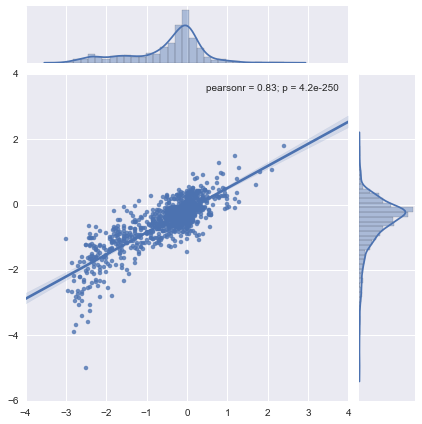

In [16]:
aggression_model = regress(comments, reg_labels['aggression'], param_grid, reg_pipeline)
joblib.dump(aggression_model, '../models/aggression_ngram.pkl')


Best parameters set found:
({'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}, -0.052081539639900046)


Grid scores:
-0.05267 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.05208 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.05322 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.05238 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.05630 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.5}
-0.05482 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.5}

Train pearson: 1.000 

Test pearson: 0.777 



['../models/aggression_ngram.pkl',
 '../models/aggression_ngram.pkl_01.npy',
 '../models/aggression_ngram.pkl_02.npy',
 '../models/aggression_ngram.pkl_03.npy',
 '../models/aggression_ngram.pkl_04.npy',
 '../models/aggression_ngram.pkl_05.npy',
 '../models/aggression_ngram.pkl_06.npy',
 '../models/aggression_ngram.pkl_07.npy',
 '../models/aggression_ngram.pkl_08.npy',
 '../models/aggression_ngram.pkl_09.npy',
 '../models/aggression_ngram.pkl_10.npy',
 '../models/aggression_ngram.pkl_11.npy',
 '../models/aggression_ngram.pkl_12.npy']

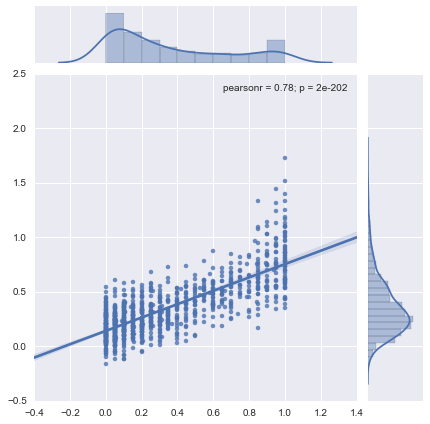

In [14]:
attack_model = regress(comments, reg_labels['attack'], param_grid, reg_pipeline)
joblib.dump(attack_model, '../models/aggression_ngram.pkl')


Best parameters set found:
({'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}, -0.035584010867280427)


Grid scores:
-0.03573 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.03558 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.01}
-0.03610 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.03576 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.1}
-0.03836 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__alpha': 0.5}
-0.03745 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__alpha': 0.5}

Train pearson: 1.000 

Test pearson: 0.790 



['../models/recipient_ngram.pkl',
 '../models/recipient_ngram.pkl_01.npy',
 '../models/recipient_ngram.pkl_02.npy',
 '../models/recipient_ngram.pkl_03.npy',
 '../models/recipient_ngram.pkl_04.npy',
 '../models/recipient_ngram.pkl_05.npy',
 '../models/recipient_ngram.pkl_06.npy',
 '../models/recipient_ngram.pkl_07.npy',
 '../models/recipient_ngram.pkl_08.npy',
 '../models/recipient_ngram.pkl_09.npy',
 '../models/recipient_ngram.pkl_10.npy',
 '../models/recipient_ngram.pkl_11.npy',
 '../models/recipient_ngram.pkl_12.npy']

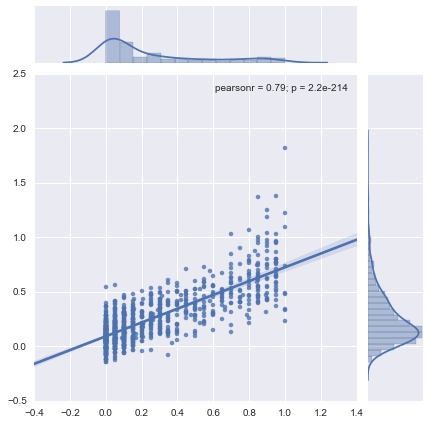

In [15]:
recipient_model = regress(comments, reg_labels['recipient'], param_grid, reg_pipeline)
joblib.dump(recipient_model, '../models/recipient_ngram.pkl')

In [17]:
# classification
# error analysis
# learning curves

In [18]:
#inspect.sort_values(by = 'pred_score', inplace = True)
#for i in range(10):
    #print(inspect.iloc[i]['score'], inspect.iloc[i]['pred_score'], inspect.iloc[i]['x'], '\n')